# 作业内容：

> 编程完成3阶辛普森积分与复化辛普森积分，以如下函数为例，与sympy的结果对比
>> $\int_{-1}^1 \sqrt{x - 1} dx$

> 计算理想强子共振气体的某些物理量，并与论文数据对比

# 参考答案

> 1， 辛普森积分

三阶辛普森积分公式如下：

$$F = (b - a)\left[ {1\over 8} f(a) + {3 \over 8} f({2a + b \over 3}) + {3 \over 8} f({a + 2 b \over 3}) + {1 \over 8} f(b) \right]$$

其中，b与a分别为积分上下限。

那么显然可得：

In [1]:
def MySimpson(f, a, b):
    return (b - a) * (f(a) + 3*f(2*a + b) + 3*f(2*b + a) + f(b)) / 8

#test using a simple function
def demo_func(x):
    return x**2
print('Simpson result: {:.3f}, analytical solutions: {:.3f}'.format(MySimpson(demo_func, 0, 1), 2))

Simpson result: 2.000, analytical solutions: 2.000


In [2]:
import numpy as np
import sympy as sym
import cmath

In [3]:
def func(x):
    return (x - 1)**0.5

In [4]:
#Sympy result
x, a, b = sym.symbols('x a b')
sym_res = complex(sym.integrate(func(x), (x, -1, 1)))
#My Simpson result
a = -1 + 0j
b = 1 + 0j
my_res = MySimpson(func, a, b)

In [5]:
#Translate into polar cordinates
sym_polar_res = cmath.polar(sym_res)
my_polar_res = cmath.polar(my_res)

复化辛普森积分就是把积分区间划分成n个子区间然后分别做辛普森积分，那么显然：

In [6]:
def MyMultiSimpson(f, a, b, n, SimpsonMethod):
    nodes = np.linspace(a, b, n)
    nodes_left = nodes[:-1]
    nodes_right = nodes[1:]
    res = [SimpsonMethod(f, item_left, item_right) for item_left, item_right in zip(nodes_left, nodes_right)]
    return np.sum(res)

In [7]:
my_multi_res = MyMultiSimpson(func, a, b, 1000, MySimpson)
my_multi_polar_res = cmath.polar(my_multi_res)

In [8]:
#Comparison
print('Cartesian\nSympy result: {}\nMy result: {}\nMy Multi-Simpson result: {}'.format(sym_res, my_res, my_multi_res))
print('Polar\nSympy result: {}\nMy result: {}\nMy Multi-Simpson result: {}'.format(sym_polar_res, my_polar_res, my_multi_polar_res))

Cartesian
Sympy result: 1.8856180831641267j
My result: (8.659560562354934e-17+1.4142135623730951j)
My Multi-Simpson result: (0.4714095442741609+1.8047382776107321j)
Polar
Sympy result: (1.8856180831641267, 1.5707963267948966)
My result: (1.4142135623730951, 1.5707963267948966)
My Multi-Simpson result: (1.8652901139249423, 1.3152984048101044)


> 2，状态方程

前面大部分内容是不用改动的，我这里直接把有用的复制过来了

In [9]:
#Unchanged part
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.integrate import quad

def dist_f(k, T, hadron):
    '''the distribution function of hadron 
    :k: float or np.array(), momentum in units [GeV]
    :T: float, temperature, [GeV]
    :hadron: dict with {'mass', '2*spin+1', 'eta',
                        'baryon_num', 'strange_num', 'charge_num'}
             where eta: +1 for fermion, -1 for boson
             
    :return: (2s + 1) / (np.exp(np.sqrt(k**2 + m**2)/T) + eta)
    '''
    spin_dof = hadron['2*spin+1']
    m = hadron['mass']
    eta = hadron['eta']
    return  spin_dof / (np.exp(np.sqrt(k**2 + m**2)/T) + eta)

def density_n(T, hadron):
    '''calc density for given temperatures
    :T: float, temperature, [GeV]
    :hadron: dict with {'mass', '2*spin+1', 'eta',
                        'baryon_num', 'strange_num', 'charge_num'}
             where eta: +1 for fermion, -1 for boson
    :return: hadron density at T '''
    # 此处 intg_n 是 inline function
    intg_n = lambda k: k**2 * dist_f(k, T, hadron) / (2 * np.pi**2)
    
    kmax = 50 * T
    # 不要直接使用 quad(f, 0, 50*T), 给 50*T 命名为 kmax，程序可读性更好
    ndensity = quad(intg_n, 0, kmax)[0]
    
    return ndensity

def pressure_p(T, hadron):
    '''HRG presure for given temperatures
    :T: float or np.array(), temperature, [GeV]
    :hadron: dict with {'mass', '2*spin+1', 'eta',
                        'baryon_num', 'strange_num', 'charge_num'}
             where eta: +1 for fermion, -1 for boson
    :return: hadron presure at T  in unit [GeV]^4 '''
    spin_dof = hadron['2*spin+1']
    m = hadron['mass']
    eta = hadron['eta']
    intg_p = lambda k:  k**2 * np.log(1 + eta * np.exp(-(np.sqrt(k**2 + m**2))/T))    
    coef_p = eta * T * spin_dof / (2 * np.pi**2)

    kmax = 50 * T
    pressure = coef_p * quad(intg_p, 0, kmax)[0] 
    return pressure

def energy_density_e(T, hadron):
    '''HRG presure for given temperatures
    :T: float or np.array(), temperature, [GeV]
    :hadron: dict with {'mass', '2*spin+1', 'eta',
                        'baryon_num', 'strange_num', 'charge_num'}
             where eta: +1 for fermion, -1 for boson 
    :return: hadron energy density at T in unit [GeV]^4'''
    m = hadron['mass']

    intg_e = lambda k: k**2 * np.sqrt(k**2 + m**2) * dist_f(k, T, hadron) / (2 * np.pi**2)
    kmax = 50 * T
    edensity = quad(intg_e, 0, kmax)[0] 
    return edensity

def eos(T, mu, hadron):
    '''calc the pressure vs energy density
    :T: float, temperature, [GeV]
    :mu: (mu_B, mu_S, mu_Q)
    :hadron: dict with {'mass', '2*spin+1', 'eta',
                        'baryon_num', 'strange_num', 'charge_num'}
             where eta: +1 for fermion, -1 for boson
    return: pressure, energy density in unit [GeV]^4，particle density'''
    pressure = pressure_p(T, hadron)
    edensity = energy_density_e(T, hadron)
    ndensity = density_n(T, hadron)
    
    return pressure, edensity, ndensity

pdg_ = []
name_ = []
mass_ = []
decay_width_ = []       # decay width
spin_degeneracy_ = []    # 2*s + 1
isbaryon_ = []
strange_num_ = []
charge_num_ = []
with open("data/pdg05.dat", "r") as pdg:
    lines = pdg.readlines()
    row = 0
    while row < len(lines):
        # 按空格将不同的数据分开
        particle = lines[row].split()
        # 最后一列存储了衰变通道个数
        decay_channels = int(particle[-1])
        row += decay_channels
        
        #print(particle[1], particle[10])
        pdg_.append(int(particle[0]))
        name_.append(particle[1])
        mass_.append(float(particle[2]))
        decay_width_.append(float(particle[3]))
        spin_degeneracy_.append(int(particle[4]))
        isbaryon_.append(int(particle[5]))
        strange_num_.append(int(particle[6]))
        charge_num_.append(int(particle[10]))
        
        row += 1
        
df = pd.DataFrame({"pdg":pdg_, 
                   "name":name_, 
                   "mass":mass_,
                   "decay_width":decay_width_,
                   "2*spin+1":spin_degeneracy_,
                   "isbaryon":isbaryon_,
                   "strange_num":strange_num_,
                   "charge_num":charge_num_})

# 给 pandas 的 DataFrame 数据多添加一列，eta

# for fermions (baryons)
df.loc[df["isbaryon"]==1, "eta"] = +1.0

# for bosons (mesons)
df.loc[df["isbaryon"]==0, "eta"] = -1.0

# pdg05.dat 中无反重子，手动添加
anti_baryon = df[df['isbaryon']==1].copy()

anti_baryon.loc[:, "pdg"] = - anti_baryon["pdg"]
anti_baryon.loc[:, "name"] = "anti" + anti_baryon["name"]
anti_baryon.loc[:, "charge_num"] = -anti_baryon["charge_num"]

df = df.append(anti_baryon, ignore_index=True)

In [10]:
def hrg_eos():
    T = np.linspace(0.1, 0.2, 20)
    mu = 0  
    pressure = []
    edensity = []
    ndensity = []
    cs2 = []
    
    for Ti in tqdm(T):
        pr = 0
        ed = 0
        nd = 0
        for i in range(len(df)):
            hadron = df.iloc[i, :]
            pr_, ed_, nd_ = eos(Ti, mu, hadron)
            pr += pr_
            ed += ed_
            nd += nd_
            
        pressure.append(pr)
        edensity.append(ed)
        ndensity.append(nd)
    
    cs2 = np.gradient(pressure, edensity)
    
    return T, np.array(pressure), np.array(edensity), np.array(ndensity), cs2

T, Pr, Ed, Nh, Cs2 = hrg_eos()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.29s/it]


论文里的数据点我没有去采集，使用的李文汐同学的数据，特此鸣谢。

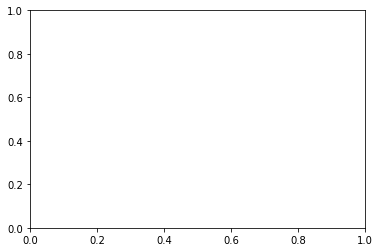

In [11]:
#initialize figure
fig, ax = plt.subplots()
# fig.set_size_inches(8, 8)

In [12]:
def AddLabelAndLegend(ax, xlabel, ylabel):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    return

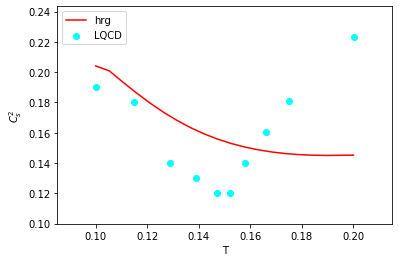

In [13]:
#Cs2
ax.cla()
data = pd.read_csv('./data/C^2_s_T.csv')
T_lqcd = data['T'] / 1000
Cs2_lqcd = data['C^2_s']
ax.scatter(T_lqcd, Cs2_lqcd, color='cyan', label='LQCD')
ax.plot(T, Cs2, color='red', label='hrg')
AddLabelAndLegend(ax, 'T', r'$C^2_s$')
fig

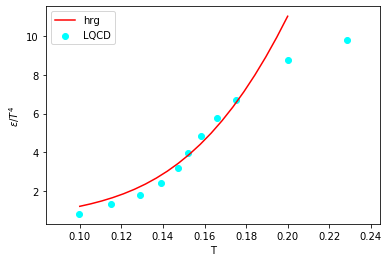

In [14]:
#e over T
ax.cla()
data = pd.read_csv('./data/energy_T.csv')
T_lqcd = data['T'] / 1000
energy_lqcd = data['energy']
ax.scatter(T_lqcd, energy_lqcd, color='cyan', label='LQCD')
ax.plot(T, Ed/T**4, color='red', label='hrg')
AddLabelAndLegend(ax, 'T', r'$\epsilon/T^4$')
fig

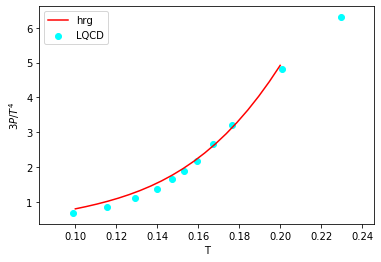

In [15]:
#P over T
ax.cla()
data = pd.read_csv('./data/pressure_T.csv')
T_lqcd = data['T'] / 1000
pressure_lqcd = data['pressure']
ax.scatter(T_lqcd, pressure_lqcd, color='cyan', label='LQCD')
ax.plot(T, 3*Pr/T**4, color='red', label='hrg')
AddLabelAndLegend(ax, 'T', r'$3P/T^4$')
fig

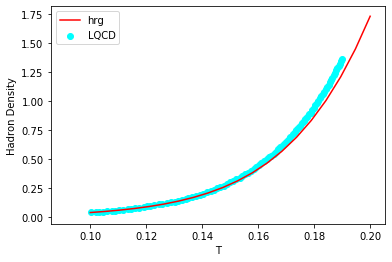

In [16]:
#hadron density
ax.cla()
data = pd.read_csv('./data/hadron_density_T.csv')
T_lqcd = data['T'] / 1000
rho_lqcd = data['hadron_density']
ax.scatter(T_lqcd, rho_lqcd, color='cyan', label='LQCD')
ax.plot(T, Nh/0.19732**3, color='red', label='hrg')
AddLabelAndLegend(ax, 'T', 'Hadron Density')
fig